## 1. Cosmetics, chemicals... it's complicated
<p>Whenever I want to try a new cosmetic item, it's so difficult to choose. It's actually more than difficult. It's sometimes scary because new items that I've never tried end up giving me skin trouble. We know the information we need is on the back of each product, but it's really hard to interpret those ingredient lists unless you're a chemist. You may be able to relate to this situation.</p>
<p><img src="https://assets.datacamp.com/production/project_695/img/image_1.png" style="width:600px;height:400px;"></p>
<p>So instead of buying and hoping for the best, why don't we use data science to help us predict which products may be good fits for us? In this notebook, we are going to create a content-based recommendation system where the 'content' will be the chemical components of cosmetics. Specifically, we will process ingredient lists for 1472 cosmetics on Sephora via <a href="https://en.wikipedia.org/wiki/Word_embedding">word embedding</a>, then visualize ingredient similarity using a machine learning method called t-SNE and an interactive visualization library called Bokeh. Let's inspect our data first.</p>

In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, Div
from bokeh.palettes import Category10
from bokeh.layouts import column
from collections import Counter
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from bokeh.io import push_notebook
import seaborn as sns
from matplotlib_venn import venn2
from IPython.display import display

In [2]:
# Step 1: Load and Inspect the Dataset
df = pd.read_csv("cosmetics.csv")
print(f"Dataset Shape: {df.shape}")
display(df.sample(5))
print("\nProduct types (Label counts):")
print(df['Label'].value_counts())

Dataset Shape: (1472, 11)


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
627,Treatment,BIOSSANCE,Squalane + Phyto-Retinol Serum,78,4.3,"Water, Squalane, Niacinamide, Sodium Acrylates...",1,1,1,1,1
753,Treatment,SHISEIDO,Bio-Performance LiftDynamic Serum,98,3.9,"Water, Dimethicone, Butylene Glycol, Glycerin,...",0,0,0,0,0
999,Face Mask,AMOREPACIFIC,TIME RESPONSE Vintage Wash-off Masque,170,5.0,"Camellia Sinensis Leaf Water, Propanediol, Gly...",1,1,1,1,0
570,Cleanser,ERNO LASZLO,Pore Refining Detox Double Cleanse,55,5.0,"Water, Propanediol, Sodium C14-16 Olefin Sulfo...",1,1,1,1,1
991,Face Mask,ALGENIST,PERFECT Clarifying Pore Corrector Mask,55,4.5,"Water, Kaolin, Glycerin, Ammonium Acryloyldime...",0,0,0,0,0



Product types (Label counts):
Label
Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: count, dtype: int64


## 2. Focus on one product category and one skin type
<p>There are six categories of product in our data (<strong><em>moisturizers, cleansers, face masks, eye creams</em></strong>, and <strong><em>sun protection</em></strong>) and there are five different skin types (<strong><em>combination, dry, normal, oily</em></strong> and <strong><em>sensitive</em></strong>). Because individuals have different product needs as well as different skin types, let's set up our workflow so its outputs (a t-SNE model and a visualization of that model) can be customized. For the example in this notebook, let's focus in on moisturizers for those with dry skin by filtering the data accordingly.</p>

In [3]:
# Step 2: Filter for Moisturizers Suitable for Dry Skin
moisturizers = df[df['Label'] == "Moisturizer"]
moisturizers_dry = moisturizers[moisturizers['Dry'] == 1].reset_index(drop=True)
print(f"Filtered Moisturizers for Dry Skin: {moisturizers_dry.shape[0]} items")


Filtered Moisturizers for Dry Skin: 190 items


## 3. Tokenizing the ingredients
<p>To get to our end goal of comparing ingredients in each product, we first need to do some preprocessing tasks and bookkeeping of the actual words in each product's ingredients list. The first step will be tokenizing the list of ingredients in <code>Ingredients</code> column. After splitting them into tokens, we'll make a binary bag of words. Then we will create a dictionary with the tokens, <code>ingredient_idx</code>, which will have the following format:</p>
<p>{ <strong><em>"ingredient"</em></strong>: index value, … }</p>

In [4]:
# Tokenize Ingredient Lists
corpus = []
ingredient_idx = {}
idx = 0

for item in moisturizers_dry['Ingredients']:
    tokens = item.lower().split(', ')
    corpus.append(tokens)
    for token in tokens:
        if token not in ingredient_idx:
            ingredient_idx[token] = idx
            idx += 1

## 4. Initializing a document-term matrix (DTM)
<p>The next step is making a document-term matrix (DTM). Here each cosmetic product will correspond to a document, and each chemical composition will correspond to a term. This means we can think of the matrix as a <em>“cosmetic-ingredient”</em> matrix. The size of the matrix should be as the picture shown below.
<img src="https://assets.datacamp.com/production/project_695/img/image_2.PNG" style="width:600px;height:250px;">
To create this matrix, we'll first make an empty matrix filled with zeros. The length of the matrix is the total number of cosmetic products in the data. The width of the matrix is the total number of ingredients. After initializing this empty matrix, we'll fill it in the following tasks. </p>

In [5]:
# Initialize Document-Term Matrix (Binary Matrix)
M = len(corpus)
N = len(ingredient_idx)
A = np.zeros((M, N))

## 5. Creating a counter function
<p>Before we can fill the matrix, let's create a function to count the tokens (i.e., an ingredients list) for each row. Our end goal is to fill the matrix with 1 or 0: if an ingredient is in a cosmetic, the value is 1. If not, it remains 0. The name of this function, <code>oh_encoder</code>, will become clear next.</p>

In [6]:
# One-Hot Encoder Function
def oh_encoder(tokens):
    x = np.zeros(N)
    for token in tokens:
        if token in ingredient_idx:
            x[ingredient_idx[token]] = 1
    return x

## 6. The Cosmetic-Ingredient matrix!
<p>Now we'll apply the <code>oh_encoder()</code> functon to the tokens in <code>corpus</code> and set the values at each row of this matrix. So the result will tell us what ingredients each item is composed of. For example, if a cosmetic item contains <em>water, niacin, decyl aleate</em> and <em>sh-polypeptide-1</em>, the outcome of this item will be as follows. 
<img src="https://assets.datacamp.com/production/project_695/img/image_3.PNG" style="width:800px;height:400px;">
This is what we called one-hot encoding. By encoding each ingredient in the items, the <em>Cosmetic-Ingredient</em> matrix will be filled with binary values. </p>

In [7]:
#  Fill in the Matrix
for i, tokens in enumerate(corpus):
    A[i] = oh_encoder(tokens)

## 7. Dimension reduction with t-SNE
<p>The dimensions of the existing matrix is (190, 2233), which means there are 2233 features in our data. For visualization, we should downsize this into two dimensions. We'll use t-SNE for reducing the dimension of the data here.</p>
<p><strong><a href="https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding">T-distributed Stochastic Neighbor Embedding (t-SNE)</a></strong> is a nonlinear dimensionality reduction technique that is well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, this technique can reduce the dimension of data while keeping the similarities between the instances. This enables us to make a plot on the coordinate plane, which can be said as vectorizing. All of these cosmetic items in our data will be vectorized into two-dimensional coordinates, and the distances between the points will indicate the similarities between the items. </p>

In [8]:
# Apply t-SNE for Dimensionality Reduction
model = TSNE(n_components=2, learning_rate=200, random_state=42)
tsne_features = model.fit_transform(A)

# Add coordinates
moisturizers_dry['X'] = tsne_features[:, 0].astype(float)
moisturizers_dry['Y'] = tsne_features[:, 1].astype(float)


## 8. Let's map the items with Bokeh
<p>We are now ready to start creating our plot. With the t-SNE values, we can plot all our items on the coordinate plane. And the coolest part here is that it will also show us the name, the brand, the price and the rank of each item. Let's make a scatter plot using Bokeh and add a hover tool to show that information. Note that we won't display the plot yet as we will make some more additions to it.</p>

In [9]:
# Step 8: Bokeh Plot Setup
source_data = {
    'X': moisturizers_dry['X'],
    'Y': moisturizers_dry['Y'],
    'Name': moisturizers_dry['Name'],
    'Brand': moisturizers_dry['Brand'],
    'Price': moisturizers_dry['Price'],
    'Rank': moisturizers_dry['Rank']
}
source = ColumnDataSource(source_data)


# Create plot
plot = figure(title="Moisturizers - Ingredient Similarity", 
             width=800, height=600)
# Add scatter plot
plot.scatter('X', 'Y', size=10, source=source,
            fill_alpha=0.6, color="navy")


GlyphRenderer(id='p1047', ...)

## 9. Adding a hover tool
<p>Why don't we add a hover tool? Adding a hover tool allows us to check the information of each item whenever the cursor is directly over a glyph. We'll add tooltips with each product's name, brand, price, and rank (i.e., rating).</p>

In [10]:
# Add Hover Tool
hover = HoverTool(tooltips=[
    ("Product", "@Name"),
    ("Brand", "@Brand"),
    ("Price", "$@Price"),
    ("Rating", "@Rank")
])
plot.add_tools(hover)

## 10. Mapping the cosmetic items
<p>Finally, it's show time! Let's see how the map we've made looks like. Each point on the plot corresponds to the cosmetic items. Then what do the axes mean here? The axes of a t-SNE plot aren't easily interpretable in terms of the original data. Like mentioned above, t-SNE is a visualizing technique to plot high-dimensional data in a low-dimensional space. Therefore, it's not desirable to interpret a t-SNE plot quantitatively.</p>
<p>Instead, what we can get from this map is the distance between the points (which items are close and which are far apart). The closer the distance between the two items is, the more similar the composition they have. Therefore this enables us to compare the items without having any chemistry background.</p>

In [11]:
# Add Summary Stats
avg_price = moisturizers_dry['Price'].mean()
top_rated = moisturizers_dry.sort_values("Rank").iloc[0]["Name"]
summary = Div(text=f"""
    <b>Average Price:</b> ${avg_price:.2f}<br>
    <b>Top Product:</b> {top_rated}
""")
# Show plot
show(column(summary, plot))


## 11. Comparing two products
<p>Since there are so many cosmetics and so many ingredients, the plot doesn't have many super obvious patterns that simpler t-SNE plots can have (<a href="https://campus.datacamp.com/courses/unsupervised-learning-in-python/visualization-with-hierarchical-clustering-and-t-sne?ex=10">example</a>). Our plot requires some digging to find insights, but that's okay!</p>
<p>Say we enjoyed a specific product, there's an increased chance we'd enjoy another product that is similar in chemical composition.  Say we enjoyed AmorePacific's <a href="https://www.sephora.com/product/color-control-cushion-compact-broad-spectrum-spf-50-P378121">Color Control Cushion Compact Broad Spectrum SPF 50+</a>. We could find this product on the plot and see if a similar product(s) exist. And it turns out it does! If we look at the points furthest left on the plot, we see  LANEIGE's <a href="https://www.sephora.com/product/bb-cushion-hydra-radiance-P420676">BB Cushion Hydra Radiance SPF 50</a> essentially overlaps with the AmorePacific product. By looking at the ingredients, we can visually confirm the compositions of the products are similar (<em>though it is difficult to do, which is why we did this analysis in the first place!</em>), plus LANEIGE's version is $22 cheaper and actually has higher ratings.</p>
<p>It's not perfect, but it's useful. In real life, we can actually use our little ingredient-based recommendation engine help us make educated cosmetic purchase choices.</p>

In [12]:
# Print the ingredients of two similar cosmetics
cosmetic_1 = moisturizers_dry[moisturizers_dry['Name'] == "Color Control Cushion Compact Broad Spectrum SPF 50+"]
cosmetic_2 = moisturizers_dry[moisturizers_dry['Name'] == "BB Cushion Hydra Radiance SPF 50"]

# Display each item's data and ingredients
display(cosmetic_1)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Ingredients.values)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
45,Moisturizer,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,60,4.0,"Phyllostachis Bambusoides Juice, Cyclopentasil...",1,1,1,1,1,-9.419198,-335.968231


['Phyllostachis Bambusoides Juice, Cyclopentasiloxane, Cyclohexasiloxane, Peg-10 Dimethicone, Phenyl Trimethicone, Butylene Glycol, Butylene Glycol Dicaprylate/Dicaprate, Alcohol, Arbutin, Lauryl Peg-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Polyhydroxystearic Acid, Sodium Chloride, Polymethyl Methacrylate, Aluminium Hydroxide, Stearic Acid, Disteardimonium Hectorite, Triethoxycaprylylsilane, Ethylhexyl Palmitate, Lecithin, Isostearic Acid, Isopropyl Palmitate, Phenoxyethanol, Polyglyceryl-3 Polyricinoleate, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Disodium Edta, Trimethylsiloxysilicate, Ethylhexyglycerin, Dimethicone/Vinyl Dimethicone Crosspolymer, Water, Silica, Camellia Japonica Seed Oil, Camillia Sinensis Leaf Extract, Caprylyl Glycol, 1,2-Hexanediol, Fragrance, Titanium Dioxide, Iron Oxides (Ci 77492, Ci 77491, Ci77499).']


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
55,Moisturizer,LANEIGE,BB Cushion Hydra Radiance SPF 50,38,4.3,"Water, Cyclopentasiloxane, Zinc Oxide (CI 7794...",1,1,1,1,1,-31.170496,-359.229309


['Water, Cyclopentasiloxane, Zinc Oxide (CI 77947), Ethylhexyl Methoxycinnamate, PEG-10 Dimethicone, Cyclohexasiloxane, Phenyl Trimethicone, Iron Oxides (CI 77492), Butylene Glycol Dicaprylate/Dicaprate, Niacinamide, Lauryl PEG-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Titanium Dioxide (CI 77891 , Iron Oxides (CI 77491), Butylene Glycol, Sodium Chloride, Iron Oxides (CI 77499), Aluminum Hydroxide, HDI/Trimethylol Hexyllactone Crosspolymer, Stearic Acid, Methyl Methacrylate Crosspolymer, Triethoxycaprylylsilane, Phenoxyethanol, Fragrance, Disteardimonium Hectorite, Caprylyl Glycol, Yeast Extract, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Trimethylsiloxysilicate, Polysorbate 80, Disodium EDTA, Hydrogenated Lecithin, Dimethicone/Vinyl Dimethicone Crosspolymer, Mica (CI 77019), Silica, 1,2-Hexanediol, Polypropylsilsesquioxane, Chenopodium Quinoa Seed Extract, Magnesium Sulfate, Calcium Chloride

Detailed comparison of products

In [13]:
# Allergen keywords to check
allergen_keywords = ['fragrance', 'alcohol', 'paraben', 'sulfate', 'benzyl', 'linalool', 'limonene']


def check_allergens(ingredients_set):
    return [a for a in allergen_keywords if any(a in ing for ing in ingredients_set)]

# Helper: Plot Venn diagram
def plot_venn(ing1, ing2, label1, label2):
    plt.figure(figsize=(6, 4))
    venn2([ing1, ing2], set_labels=(label1, label2))
    plt.title("Ingredient Overlap")
    plt.show()

# Helper: Plot similarity gauge
def plot_similarity(sim_score):
    plt.figure(figsize=(5, 1))
    plt.barh([0], [sim_score], color='green')
    plt.xlim(0, 1)
    plt.title(f"Cosine Similarity: {sim_score:.2f}")
    plt.yticks([])
    plt.show()

# Helper: Plot side-by-side metrics
def plot_metrics_comparison(p1, p2):
    metrics = ['Price', 'Rank', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']
    p1_vals = [p1[m] for m in metrics]
    p2_vals = [p2[m] for m in metrics]

    x = range(len(metrics))
    plt.figure(figsize=(10, 4))
    plt.bar(x, p1_vals, width=0.4, label=p1['Name'], align='center')
    plt.bar([i + 0.4 for i in x], p2_vals, width=0.4, label=p2['Name'], align='center')
    plt.xticks([i + 0.2 for i in x], metrics, rotation=45)
    plt.title("Metric Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Core comparison function
def compare_products_full(index1, index2):
    product1 = moisturizers_dry.iloc[index1]
    product2 = moisturizers_dry.iloc[index2]

    sim = cosine_similarity([A[index1]], [A[index2]])[0][0]

    ingredients1 = set(ing.strip().lower() for ing in product1['Ingredients'].split(','))
    ingredients2 = set(ing.strip().lower() for ing in product2['Ingredients'].split(','))

    common_ingredients = ingredients1 & ingredients2
    unique_to_1 = ingredients1 - ingredients2
    unique_to_2 = ingredients2 - ingredients1

    allergens1 = check_allergens(ingredients1)
    allergens2 = check_allergens(ingredients2)

    price_diff = product1['Price'] - product2['Price']
    rank_diff = product1['Rank'] - product2['Rank']

    with output:
        output.clear_output()
        print(f"\n=== COMPARISON: \"{product1['Name']}\" vs \"{product2['Name']}\" ===")
        print(f"Brand: {product1['Brand']} | {product2['Brand']}")
        print(f"Cosine Similarity (Ingredients): {sim:.2f}")
        print(f"Price: ${product1['Price']:.2f} | ${product2['Price']:.2f} (Δ ${abs(price_diff):.2f})")
        print(f"Rank: {product1['Rank']} | {product2['Rank']} (Δ {abs(rank_diff)} stars)")

        print("\nSkin Types (1 = Suitable, 0 = Not):")
        for skin in ['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']:
            print(f"{skin}: {product1[skin]} | {product2[skin]}")

        print("\n=== INGREDIENTS ===")
        print(f"Common Ingredients ({len(common_ingredients)}):")
        print(', '.join(sorted(common_ingredients)) if common_ingredients else "None")

        print(f"\nUnique to \"{product1['Name']}\" ({len(unique_to_1)}):")
        print(', '.join(sorted(unique_to_1)) if unique_to_1 else "None")

        print(f"\nUnique to \"{product2['Name']}\" ({len(unique_to_2)}):")
        print(', '.join(sorted(unique_to_2)) if unique_to_2 else "None")

        print("\n=== ALLERGENS ===")
        print(f"{product1['Name']}: {', '.join(allergens1) if allergens1 else 'None'}")
        print(f"{product2['Name']}: {', '.join(allergens2) if allergens2 else 'None'}")

        # Visuals
        plot_similarity(sim)
        plot_venn(ingredients1, ingredients2, product1['Name'], product2['Name'])
        plot_metrics_comparison(product1, product2)

# Dropdowns & Button
sorted_names = sorted([(name, idx) for idx, name in enumerate(moisturizers_dry['Name'])], key=lambda x: x[0])

dropdown1 = widgets.Dropdown(options=sorted_names, description='Product 1')
dropdown2 = widgets.Dropdown(options=sorted_names, description='Product 2')
compare_button = widgets.Button(description='Compare Products', button_style='success')
output = widgets.Output()

def on_compare_clicked(b):
    compare_products_full(dropdown1.value, dropdown2.value)

compare_button.on_click(on_compare_clicked)

# Display UI
display(widgets.HBox([dropdown1, dropdown2, compare_button]), output)


Output()

### TOP 20 COMMON INGREDIENTS
Let us also see the TOP 20 commonly used ingredients in Moisturizers for dry skin 

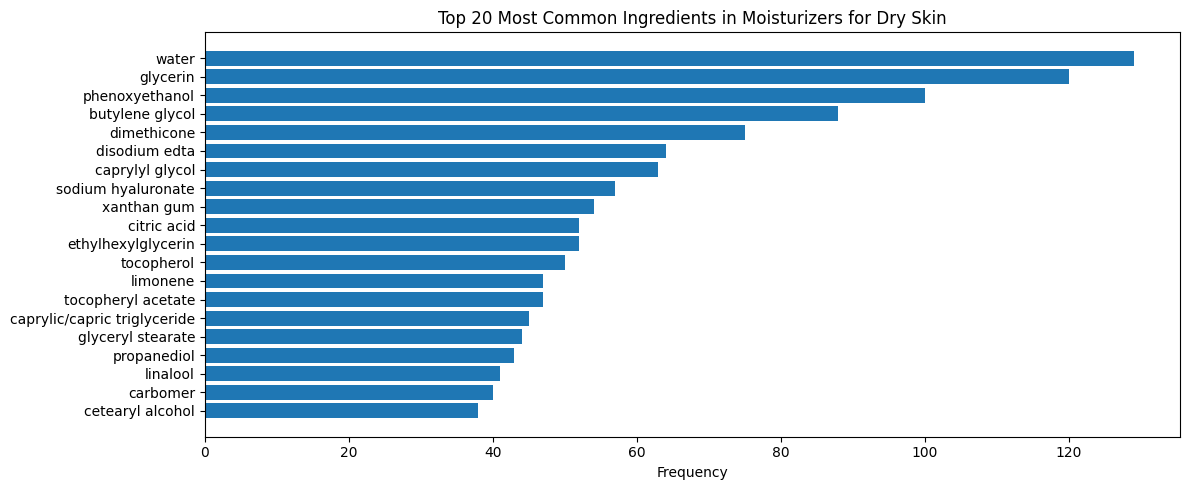

In [14]:
# Ingredient Frequency Visualization
flat_ingredients = [item for sublist in corpus for item in sublist]
counter = Counter(flat_ingredients)
common = counter.most_common(20)

ingredients, counts = zip(*common)
plt.figure(figsize=(12,5))
plt.barh(ingredients[::-1], counts[::-1])
plt.title("Top 20 Most Common Ingredients in Moisturizers for Dry Skin")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


In [15]:
# Save enhanced data and matrices for use in enhancement tools
moisturizers_dry.to_csv("moisturizers_dry.csv", index=False)
np.save("ingredient_matrix.npy", A)
np.save("corpus.npy", np.array(corpus, dtype=object))
